In [0]:
def input_fn(mode, params):
  assert 'batch_size' in params
  assert 'noise_dims' in params
  bs = params['batch_size']
  nd = params['noise_dims']
  split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  just_noise = (mode == tf.estimator.ModeKeys.PREDICT)
  
  noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
              .map(lambda _: tf.random_normal([bs, nd])))
  
  if just_noise:
    return noise_ds

  def _preprocess(element):
    # Map [0, 255] to [-1, 1].
    images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5
    return images

  images_ds = (tfds.load('mnist', split=split)
               .map(_preprocess)
               .cache()
               .repeat())
  if shuffle:
    images_ds = images_ds.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  images_ds = (images_ds.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

  return tf.data.Dataset.zip((noise_ds, images_ds))

In [0]:
list_ds = tf.data.Dataset.list_files(str(root_path + 'data/DIV2K_train_HR/hr_images/*'), shuffle = False)

In [0]:
for f in list_ds.take(5):
  print(f.numpy())

b'gdrive/My Drive/SRGAN Project/data/DIV2K_train_HR/hr_images/0001.png'
b'gdrive/My Drive/SRGAN Project/data/DIV2K_train_HR/hr_images/0002.png'
b'gdrive/My Drive/SRGAN Project/data/DIV2K_train_HR/hr_images/0003.png'
b'gdrive/My Drive/SRGAN Project/data/DIV2K_train_HR/hr_images/0004.png'
b'gdrive/My Drive/SRGAN Project/data/DIV2K_train_HR/hr_images/0005.png'


In [0]:


def decode_img(img, hr_img_shape = (96, 96) , lr_img_shape = (64, 64), original_image_shape = (2048, 1080) ):

  IMG_WIDTH, IMG_HEIGHT = hr_img_shape
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)

  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  
  # resize the image to the desired size.
  hr_img = tf.image.resize_with_crop_or_pad(img, IMG_HEIGHT , IMG_WIDTH) 

  # lr_img = tf.image.resize(img, [ int(original_img_shape[1]//4), int(original_img_shape[0]//4) ]  , method = 'bicubic' ) 
  # scipy.misc.imresize

  # lr_final_shape = np.min(int(original_img_shape[1]//4), int(original_img_shape[0]//4)) 

  lr_img = tf.image.resize(hr_img, [ int(hr_img_shape[1]//4), int(hr_img_shape[0]//4) ]  , method = 'bicubic' ) 

  return lr_img, hr_img




In [0]:
discriminator_img_shape = (256, 256)
original_img_shape = (2048, 1080)
generator_img_shape = (96, 96)
def process_path(file_path, hr_img_shape = discriminator_img_shape , lr_img_shape = generator_img_shape, original_image_shape = original_img_shape ):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  lr_img, hr_img = decode_img(img , hr_img_shape = hr_img_shape , lr_img_shape = lr_img_shape ,original_image_shape = original_image_shape )
  return lr_img , hr_img

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
images_ds = list_ds.map(process_path, num_parallel_calls= AUTOTUNE)

In [0]:
images_ds

<DatasetV1Adapter shapes: ((64, 64, 3), (256, 256, 3)), types: (tf.float32, tf.float32)>

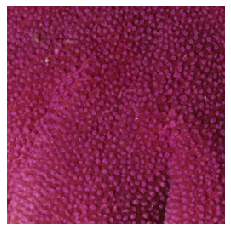

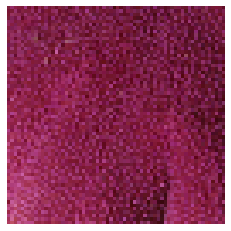

In [0]:
 
numpy_imgs1 = next(tfds.as_numpy(images_ds))[1]
numpy_imgs2 = next(tfds.as_numpy(images_ds))[0]

# img_grid = tfgan.eval.python_image_grid(numpy_imgs1, grid_shape=(10, 10))
# img_grid2 = tfgan.eval.python_image_grid(numpy_imgs2, grid_shape=(10, 10))
plt.axis('off')
plt.imshow(numpy_imgs1)
plt.show()

plt.axis('off')
plt.imshow(numpy_imgs2)
plt.show()

In [0]:
lr_img_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(lr_img))
hr_img_ds = images_ds.interleave(lambda lr_img,hr_img: tf.data.Dataset.from_tensors(hr_img))

In [0]:
for images in hr_img_ds.take(1):
  print("Image shape: ", images.shape)

Image shape:  (256, 256, 3)


In [0]:

def show_hr_image(image, label = 'high resolution image example', img_ids_hr = 1):
  image = (tf.cast(image, tf.float32) * 127.5 ) + 127.5
  plt.figure(figsize=(10, 10))
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')
  plt.savefig(root_path + "example_images/highres/img_{}.png" .format(img_ids_hr ) )


def show_lr_image(image, label = 'low resolution image example', img_ids_lr = 1):
  image = (tf.cast(image, tf.float32) * 255.0 ) 
  plt.figure(figsize=(10, 10))
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')
  plt.savefig(root_path + "example_images/lowres/img{}.png" .format(img_ids_lr ) )



In [0]:
def _hr_preprocess(element):
    # Map [0, 255] to [-1, 1].
    images = (tf.cast(element, tf.float32) - 127.5) / 127.5
    return images

def _lr_preprocess(element):

    # Map [0, 255] to [0, 1].
    images = (tf.cast(element, tf.float32)) / 255.0
    
    return images

In [0]:
highres_images = hr_img_ds.map(_hr_preprocess)

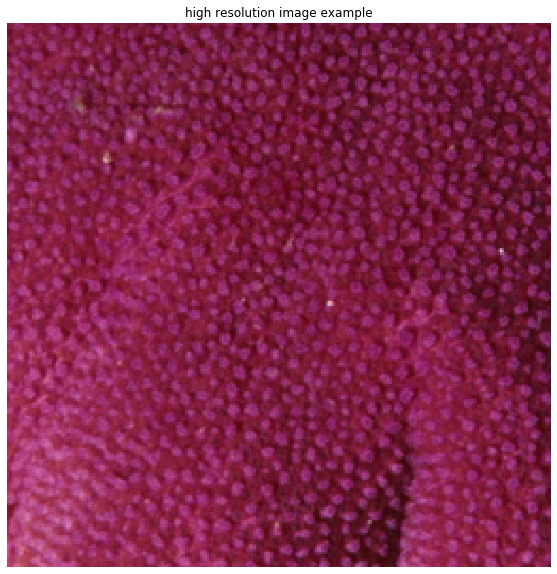

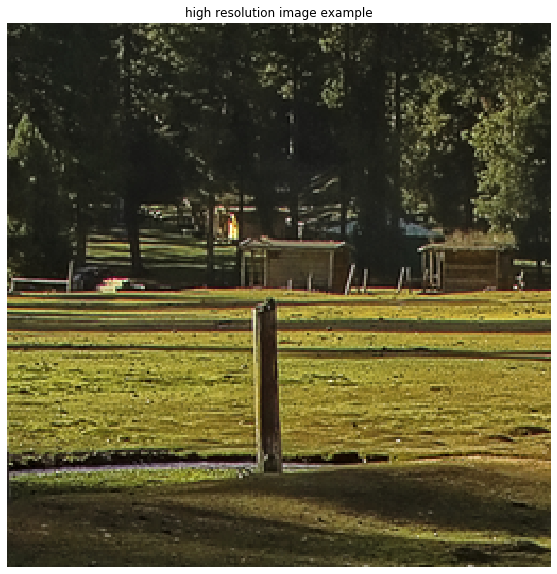

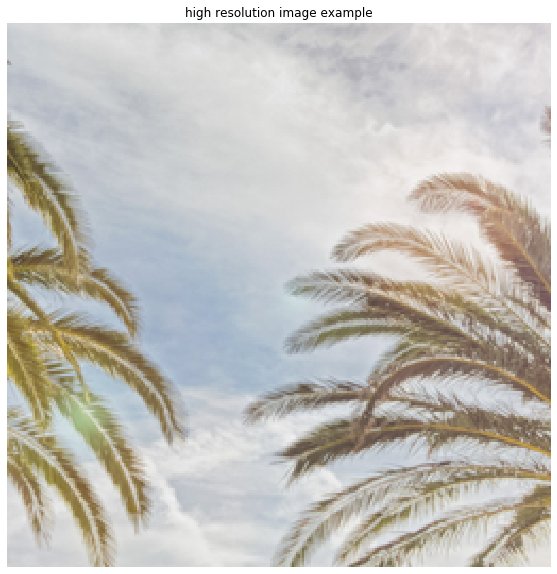

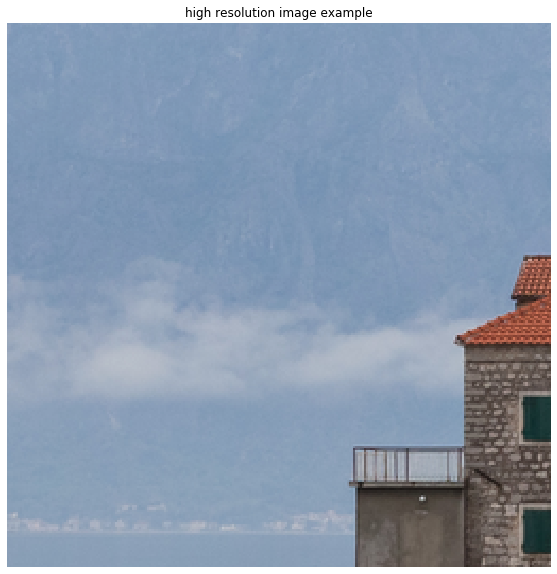

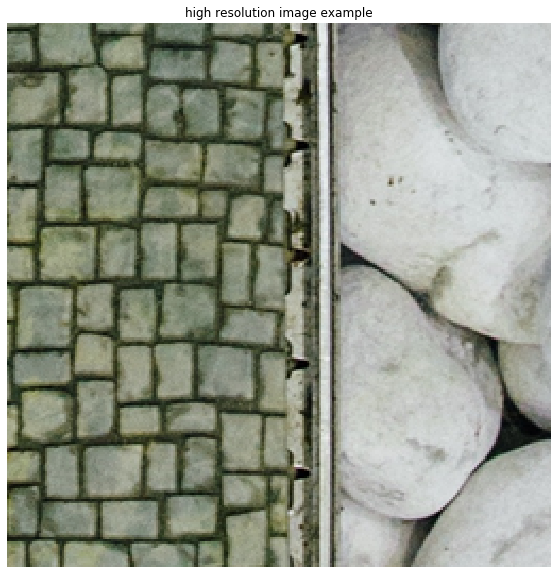

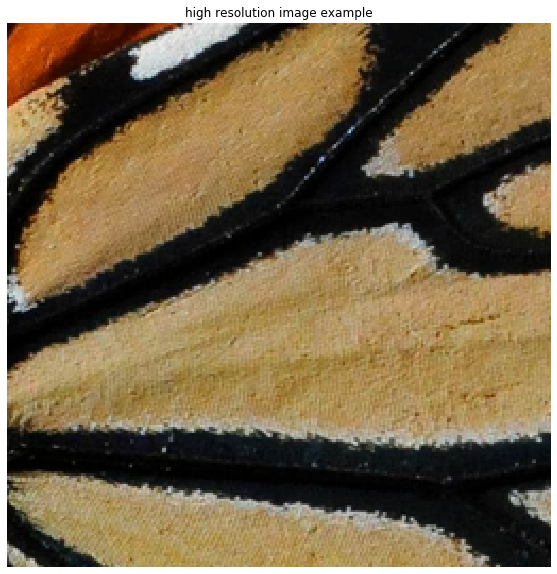

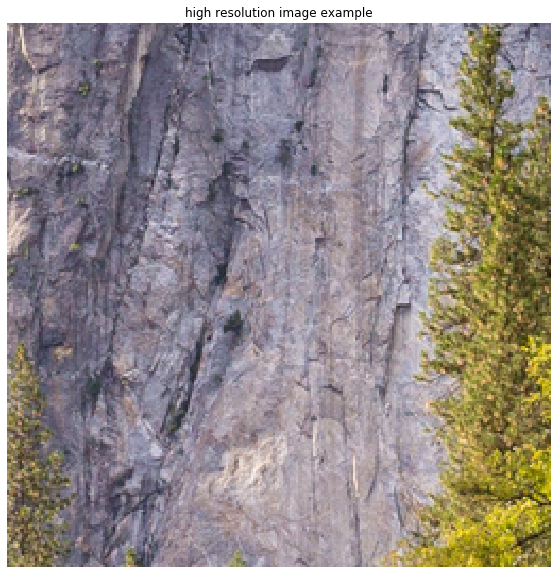

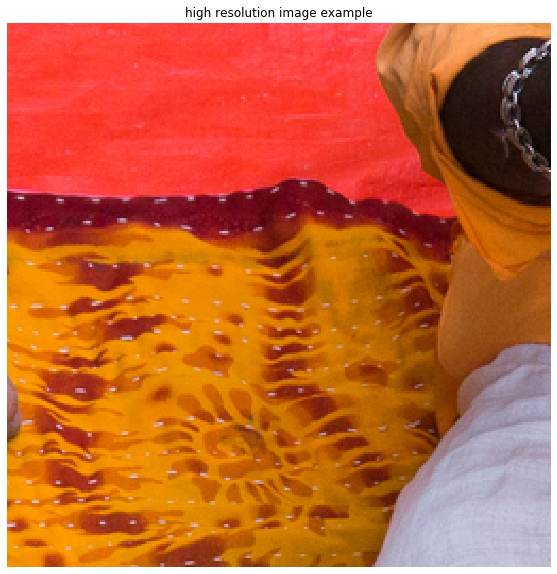

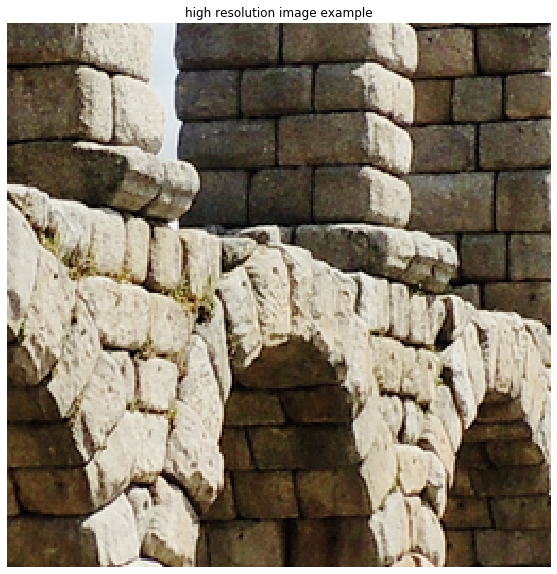

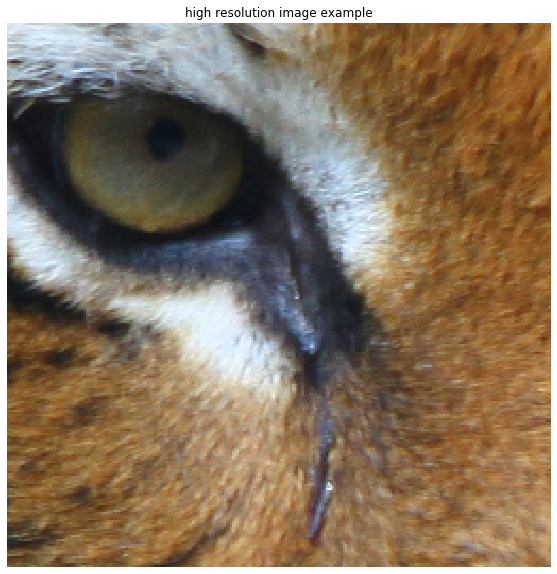

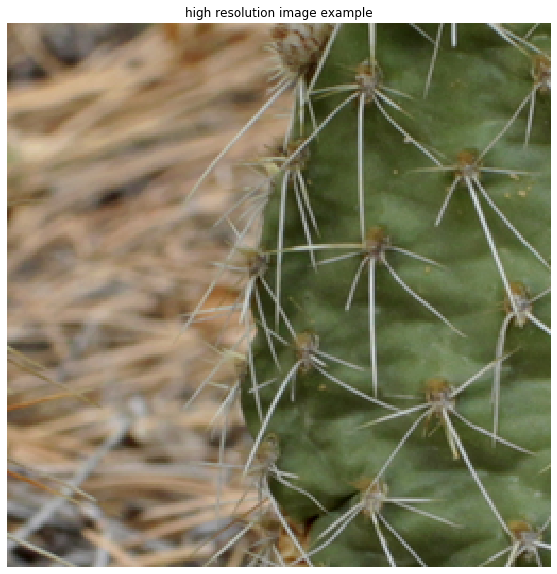

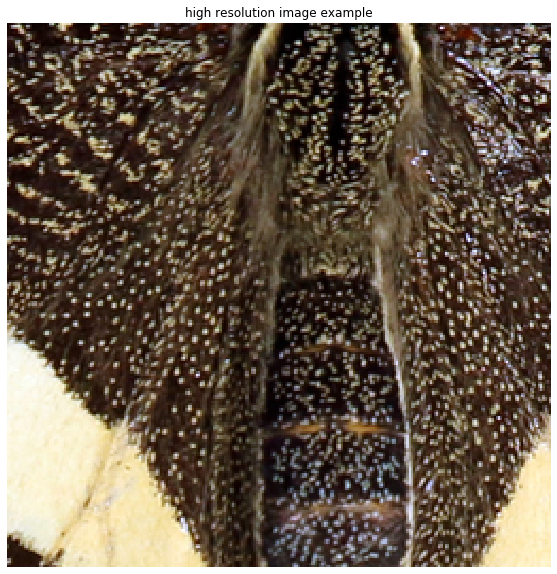

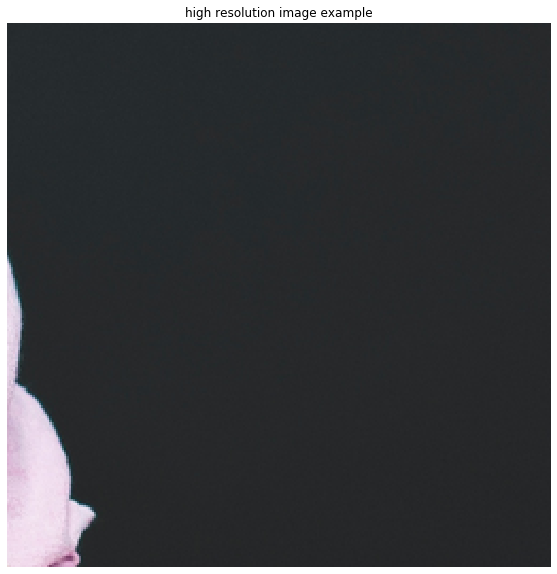

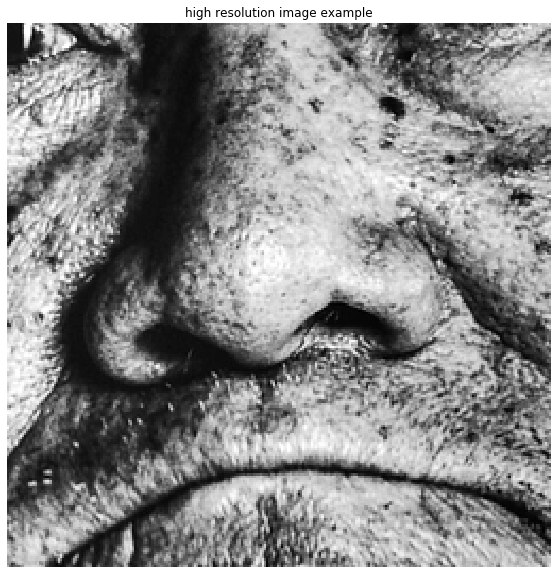

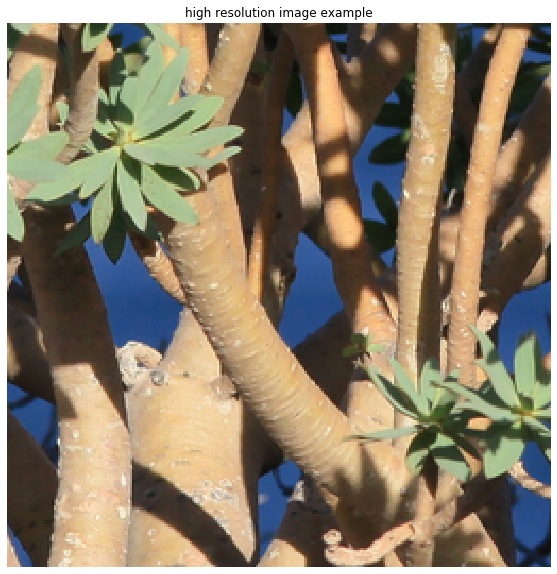

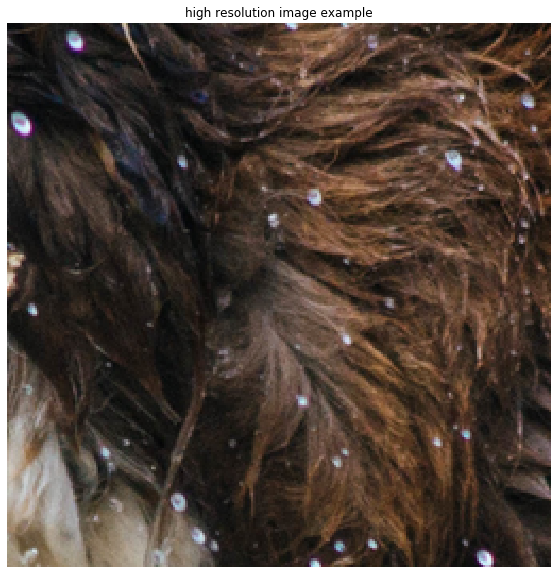

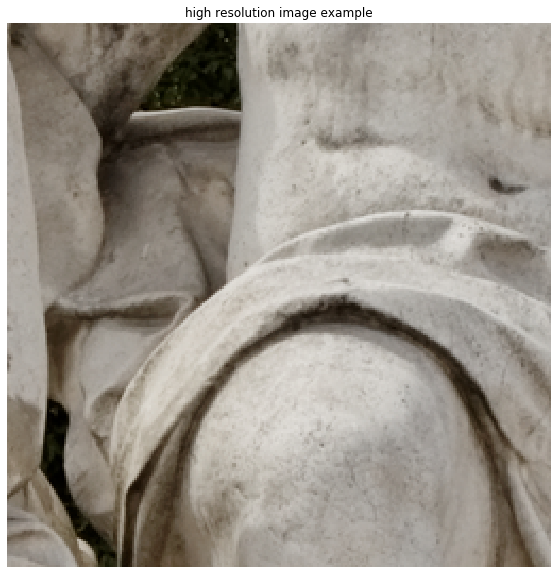

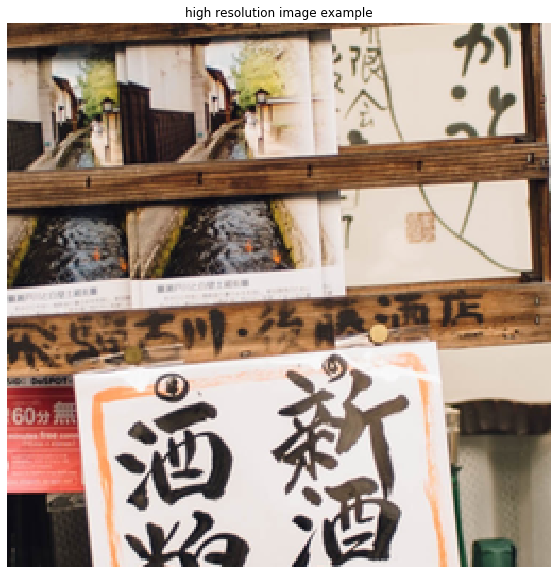

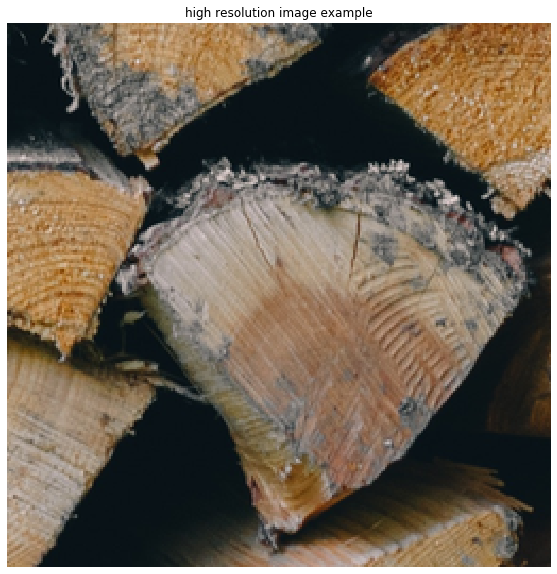

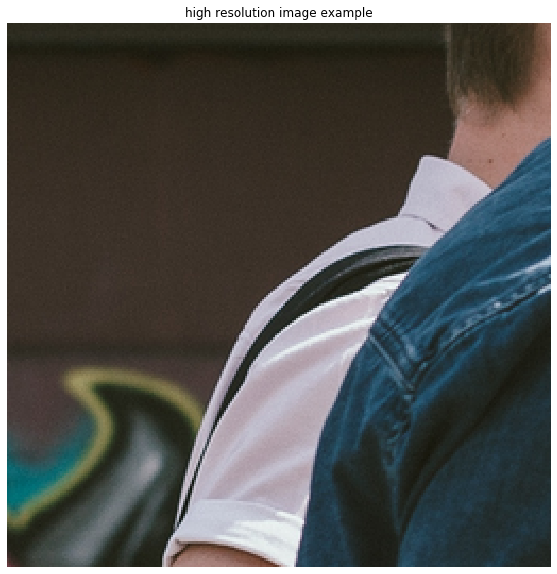

In [0]:

for i, image1 in enumerate(highres_images.take(20)):  
  show_hr_image(image1, img_ids_hr = i+1)


In [0]:
lowres_images = lr_img_ds.map(_lr_preprocess)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

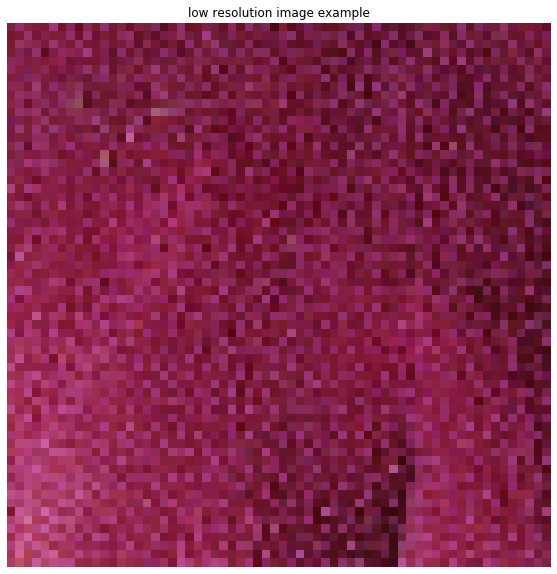

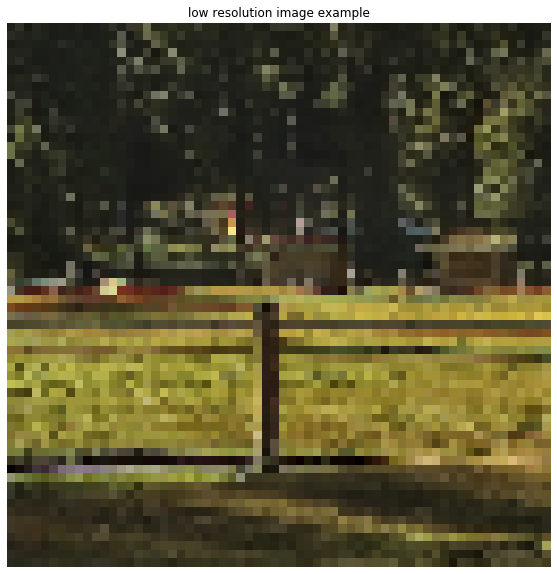

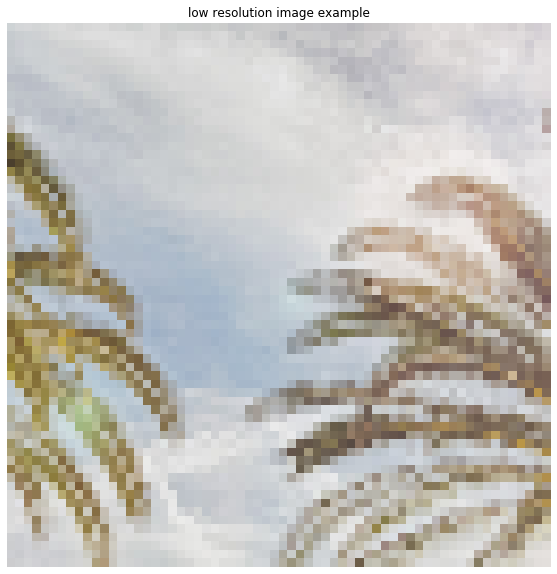

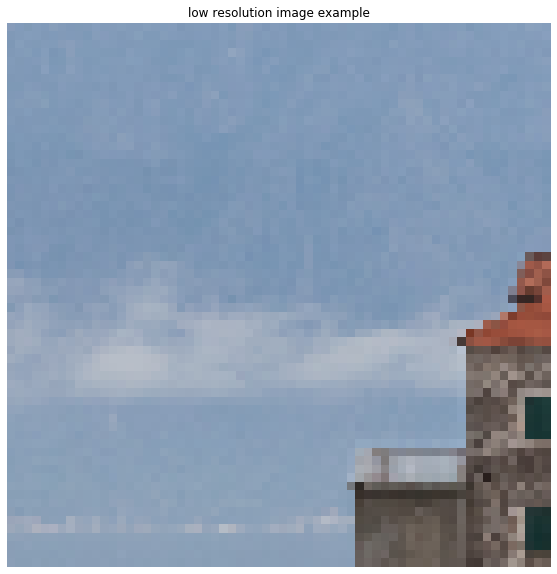

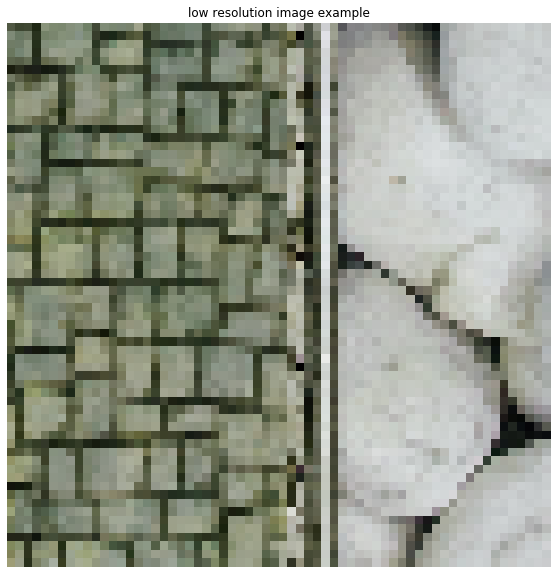

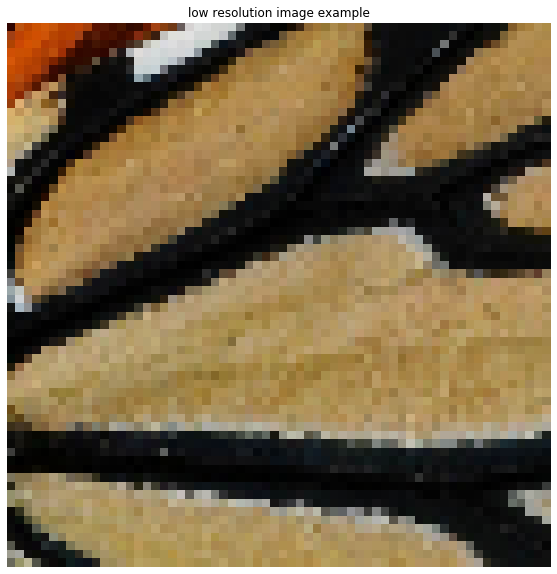

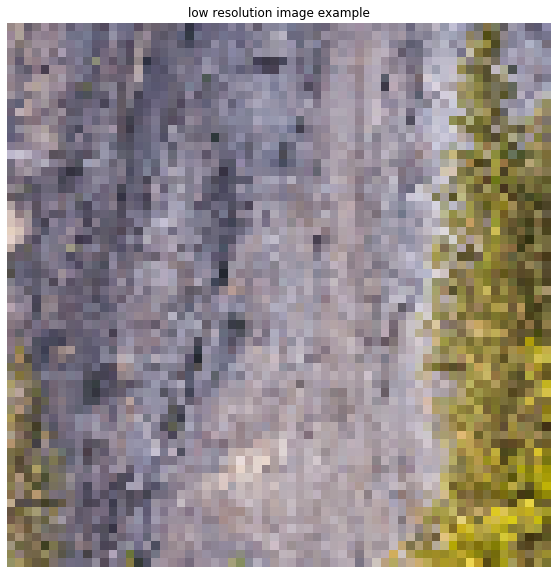

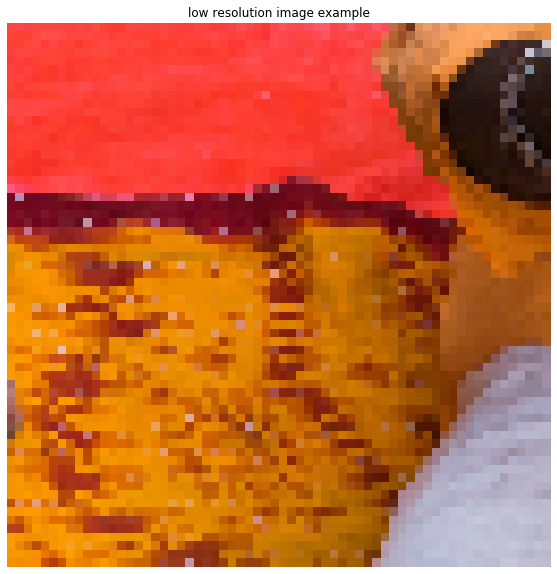

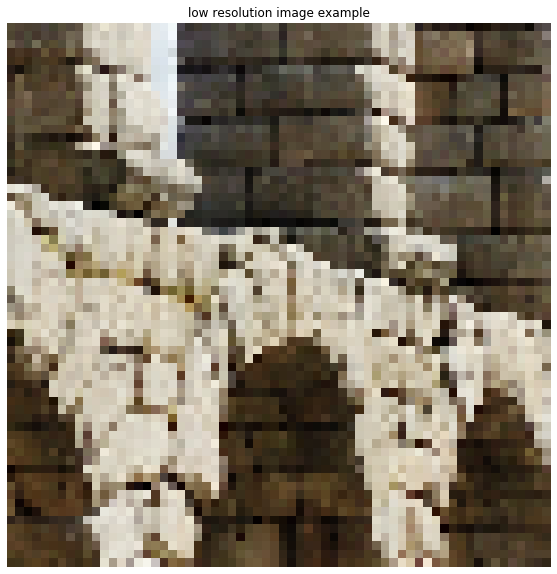

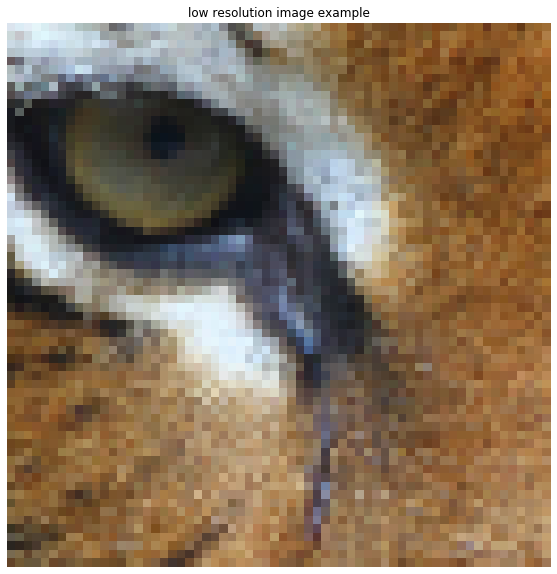

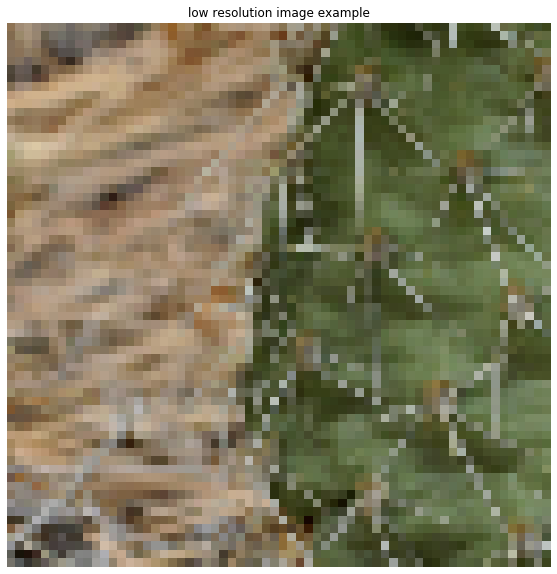

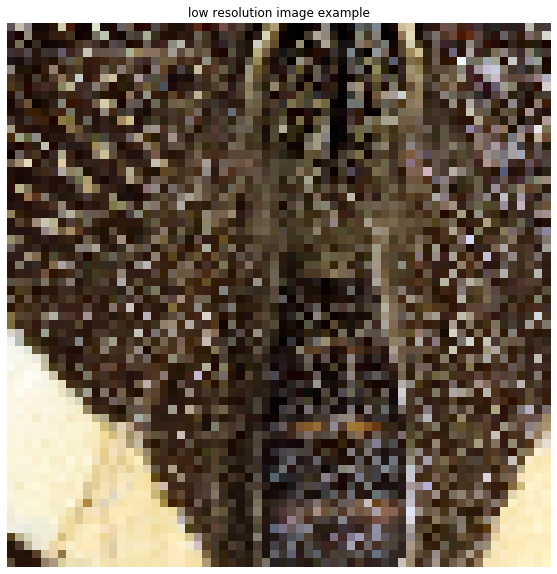

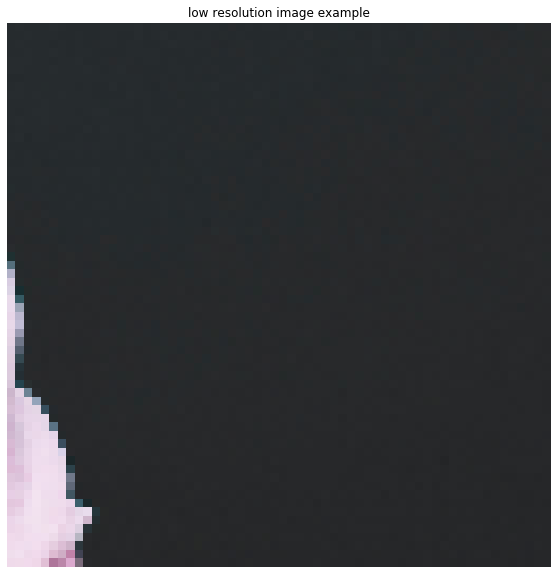

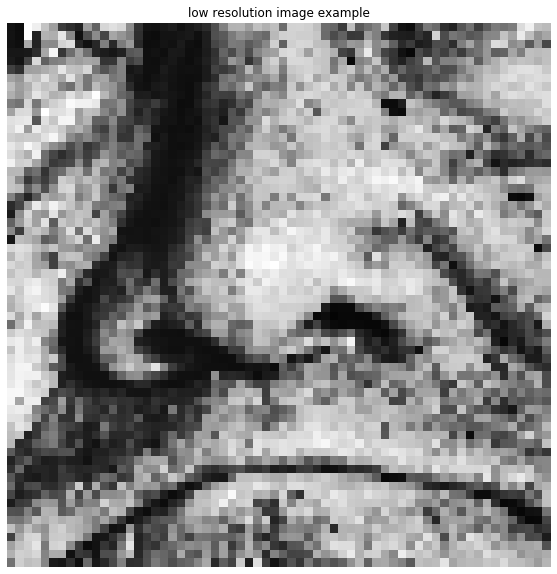

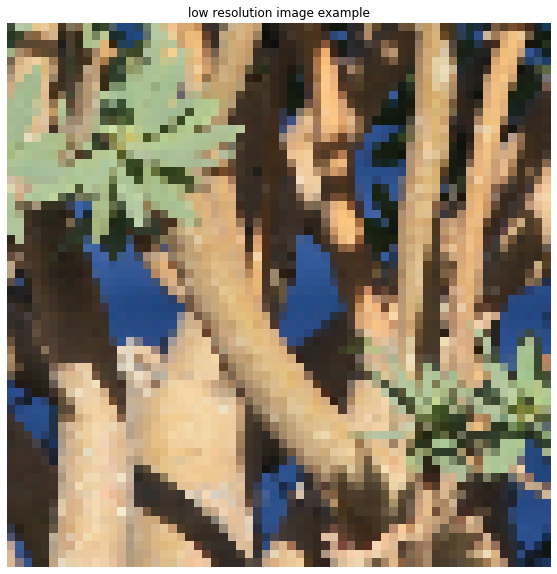

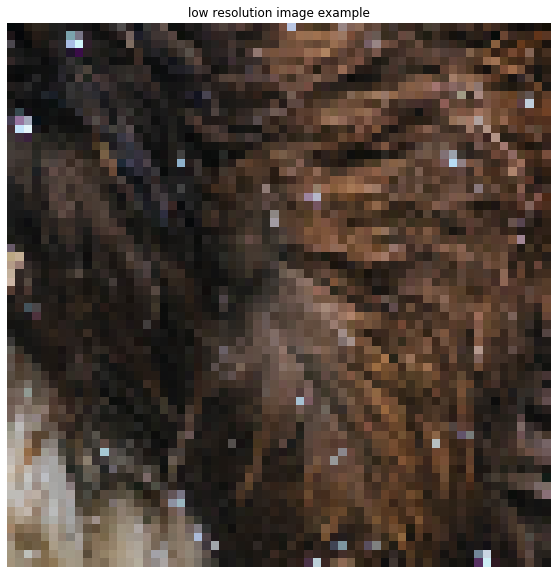

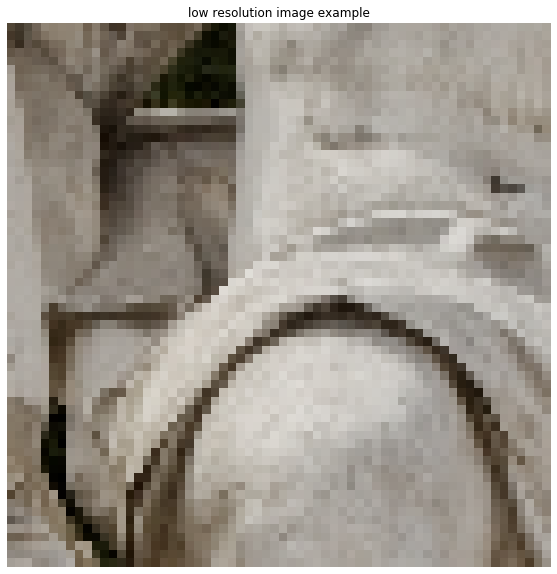

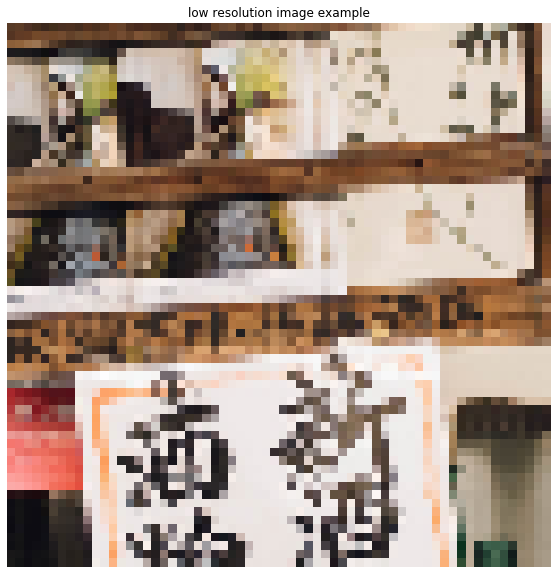

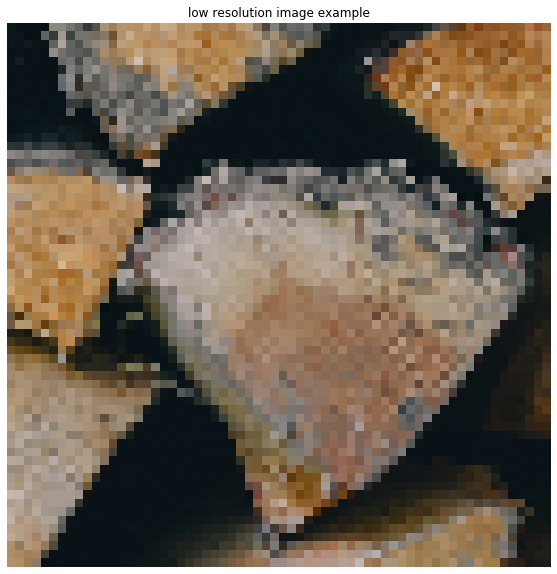

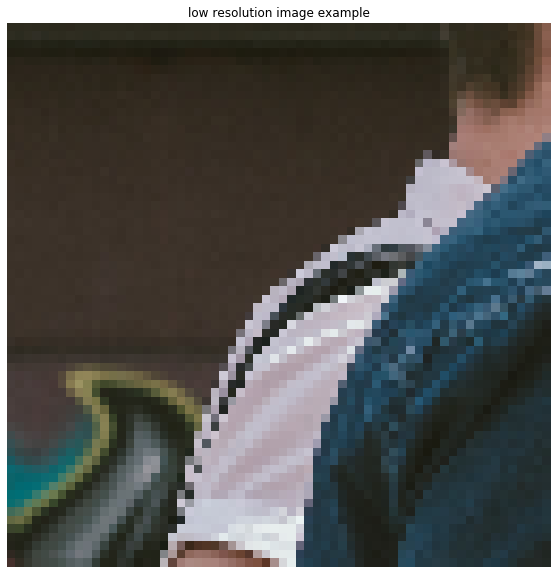

In [0]:

for j,image2 in enumerate(lowres_images.take(20)):  
  show_lr_image(image2, img_ids_lr= j + 1 )

### Using flow generator

In [0]:
# input_images = tf.keras.utils.get_file(
#     'data/DIV2K_train_HR', origin = root_path)

In [0]:
input_images = root_path + 'data/DIV2K_train_HR/'
img_gen = tf.keras.preprocessing.image.ImageDataGenerator()
images, labels = next(img_gen.flow_from_directory(input_images))

Found 800 images belonging to 1 classes.


In [0]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 256, 256, 3)
float32 (32, 1)


In [0]:
input_images_ds = tf.data.Dataset.from_generator(
    img_gen.flow_from_directory, 
    output_types=(tf.float32),
    output_shapes = ([None,96,96,3])
)

input_images_ds

<DatasetV1Adapter shapes: (None, 96, 96, 3), types: tf.float32>

In [0]:
input_images_ds.shuffle(buffer_size=10000, reshuffle_each_iteration=True).repeat()

<DatasetV1Adapter shapes: (None, 96, 96, 3), types: tf.float32>

TypeError: ignored

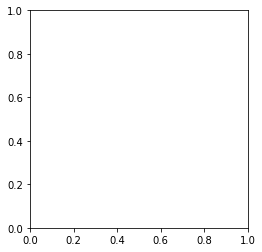

In [0]:
show() 

In [0]:
def combined_loss3(gan_model):

    # Define non-adversarial loss - for example "VGG loss"

    non_adversarial_loss = content_loss(gan_model.real_data, gan_model.generated_data)


    # Define generator loss
    generator_loss_value =  generator_loss(gan_model.discriminator_gen_outputs)
    # generator_loss = tfgan.losses.modified_generator_loss(gan_model)

    # Combine these losses - you can specify more parameters
    # Exactly one of weight_factor and gradient_ratio must be non-None

    combined_loss = non_adversarial_loss + (0.001 * generator_loss_value)

    # combined_loss = tfgan.losses.wargs.combine_adversarial_loss(
    #     non_adversarial_loss,
    #     generator_loss,
     #    weight_factor=FLAGS.weight_factor,
     #    gradient_ratio=None,
      #   variables=gan_model.generator_variables,
      #   scalar_summaries=kwargs['add_summaries'],
      #   gradient_summaries=kwargs['add_summaries'])

    return combined_loss

In [0]:
########### On training data ####################
  # Calculate some metrics.
  train_metrics = gan_estimator.evaluate(input_fn, steps=batches_for_eval_metrics, name='train_data')
  steps.append(cur_step)
  train_psnr_scores.append(train_metrics['psnr_score'])
  print('PSNR Score on train data: %.2f   ' % (train_psnr_scores[-1]))
  
  # Vizualize some images.
  train_iterator = gan_estimator.predict(
      input_fn, hooks=[tf.train.StopAtStepHook(num_steps=21)])
  try:
    imgs = np.array([next(train_iterator) for _ in range(5)])
  except StopIteration:
    pass
  tiled = tfgan.eval.python_image_grid((imgs + 1.0) /2.0 , grid_shape=(1, 5))
  plt.figure(figsize=(20,5))
  plt.axis('off')
  plt.imshow(np.squeeze(tiled))
  plt.show()